# Análise Preditiva - Reconhecimento de Imagens de Satélite no Torchvision

Neste Jupyter Notebook será utilizado técnicas de reconhecimento de imagens de satélite com Torchvision através da linguagem Python. Outro ponto desta análise é verificar o impacto e interpretação de diferentes funções de ativação na construção de um modelo de alta precisão.

Será usado  o  Torchvision  para  construir  um modelo  de  Visão  Computacional  com arquitetura de Deep Learning para classificar as imagens, avaliando o impacto e interpretação no uso de funções de ativação. Ao final teremos um modelo de classificação de imagens de satélites.

Fonte dos dados: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification

## Etapa 1 - Preparação dos dados
Nesta seção será feito a criação dos diretórios e preparação do ambiente para o início da modelagem

## 1. Carga dos pacotes

In [ ]:
# Verifica a versão do Python
from platform import python_version
print('A versão utilizada do Python neste Jupyter Notebook é: ', python_version())

A versão utilizada do Python neste Jupyter Notebook é:  3.9.13


In [ ]:
# Carga dos pacotes para a preparação dos dados
import os
import numpy as np
import shutil

## 2. Criação de pastas no diretório

In [ ]:
# Define nome da pasta onde estão os dados originais
pasta_dados_originais = 'data'

In [ ]:
# Define o nome das classes das imagens
nomes_classes = ['cloudy', 'desert', 'green_area', 'water']

In [ ]:
# Loop para criação de subpastas com as classes das imagens
for i in range(len(nomes_classes)):
    
    # Extrai o nome de cada classe
    classe = '/' + nomes_classes[i]
    
    # Cria as subpastas
    os.makedirs('dados/treino/' + nomes_classes[i])
    os.makedirs('dados/val/' + nomes_classes[i])
    os.makedirs('dados/teste/' + nomes_classes[i])

## 3. Input de dados nas subpastas

In [ ]:
# loop
for k in range(len(nomes_classes)):
    
    # Extrai um nome de classe
    nome_classe = nomes_classes[k]
    
    # Define a fonte
    src = pasta_dados_originais + '/' + nome_classe
    
    # Mostra qual classe estamos processando
    print('\nClasse:', nomes_classes[k])
    
    # Lista o conteúdo da pasta
    allFileNames = os.listdir(src)
    
    # Set aletório dos dados
    np.random.shuffle(allFileNames)
    
    # Divisão = 70% treino, 15% teste, 15% validação
    train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)*0.7), int(len(allFileNames)*0.85)])
    # Nome dos arquivos
    train_FileNames = [src + '/' + name for name in train_FileNames.tolist()]
    val_FileNames = [src + '/' + name for name in val_FileNames.tolist()]
    test_FileNames = [src + '/' + name for name in test_FileNames.tolist()]
    
    # Print
    print('Número Total de Imagens: ', len(allFileNames))
    print('Imagens de Treino: ', len(train_FileNames))
    print('Imagens de Validação: ', len(val_FileNames))
    print('Imagens de Teste: ', len(test_FileNames))
    
    # Copia das imagens
    for name in train_FileNames:
        shutil.copy(name, 'dados/treino/' + nome_classe)
    
    for name in val_FileNames:
        shutil.copy(name, 'dados/val/' + nome_classe)
        
    for name in test_FileNames:
        shutil.copy(name, 'dados/teste/' + nome_classe)
    


Classe: cloudy
Número Total de Imagens:  1500
Imagens de Treino:  1050
Imagens de Validação:  225
Imagens de Teste:  225

Classe: desert
Número Total de Imagens:  1131
Imagens de Treino:  791
Imagens de Validação:  170
Imagens de Teste:  170

Classe: green_area
Número Total de Imagens:  1500
Imagens de Treino:  1050
Imagens de Validação:  225
Imagens de Teste:  225

Classe: water
Número Total de Imagens:  1500
Imagens de Treino:  1050
Imagens de Validação:  225
Imagens de Teste:  225


## Etapa 2 - Modelagem Preditiva com Torchvision
Nesta seção do Jupyter Notebook será feito a modelagem propriamente dita para o reconhecimento de imagens de satélite.

## 1. Carga e instalação dos pacotes

In [ ]:
# Instala Torch
!pip install -q torch==1.13.0

In [ ]:
# Instala Torchvision
!pip install -q torchvision==0.14.0

In [ ]:
# Instala o watermark
!pip install -q -U watermark

In [ ]:
# Carga dos pacotes

# Pacotes para processamento e visualização dos dados
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# Pacotes Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler

# Pacotes Torchvision
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models

# Pacote do Lightning
import pytorch_lightning as pl

# Pacotes para relatório do ambiente
import gc
import types
import pkg_resources

# Pacote para operar o SO
import os
# Pacote para time
import time

# Gráficos no Jupyter Notebook
%matplotlib inline

In [ ]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Lab03 - Imagens por Satélite" --iversions

Author: Lab03 - Imagens por Satélite

matplotlib       : 3.5.2
torchvision      : 0.14.0
numpy            : 1.21.5
torch            : 1.13.0
pytorch_lightning: 1.8.3
sklearn          : 1.0.2



## 2. Verifica o ambiente de desenvolvimento

In [ ]:
# Relatório completo

# Verificando o dispositivo
processing_device = "cuda" if torch.cuda.is_available() else "cpu"

# Verificando se GPU pode ser usada (isso depende da plataforma CUDA estar instalada)
torch_aval = torch.cuda.is_available()

# Labels para o relatório de verificação
lable_1 = 'Visão Geral do Ambiente'
lable_2 = 'Se NVIDIA-SMI não for encontrado, então CUDA não está disponível'
lable_3 = 'Fim da Checagem'

# Função para verificar o que está importado nesta sessão
def get_imports():

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):            
            name = val.__module__.split(".")[0]

        poorly_named_packages = {"PIL": "Pillow", "sklearn": "scikit-learn"}

        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

# Imports nesta sessão
imports = list(set(get_imports()))

# Loop para verificar os requerimentos
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
        
# Pasta com os dados (quando necessário)
pasta_dados = r'dados'

print(f'{lable_1:-^100}')
print()
print(f"Device:", processing_device)
print(f"Pasta de Dados: ", pasta_dados)
print(f"Versões dos Pacotes Requeridos: ", requirements)
print(f"Dispositivo Que Será Usado Para Treinar o Modelo: ", processing_device)
print(f"CUDA Está Disponível? ", torch_aval)
print("Versão do PyTorch: ", torch.__version__)
print("Versão do Lightning: ", pl.__version__)
print()
print(f'{lable_2:-^100}\n')
!nvidia-smi
gc.collect()
print()
print(f"Limpando a Memória da GPU (se disponível): ", torch.cuda.empty_cache())
print(f'\n{lable_3:-^100}')

--------------------------------------Visão Geral do Ambiente---------------------------------------

Device: cpu
Pasta de Dados:  dados
Versões dos Pacotes Requeridos:  [('matplotlib', '3.5.2'), ('numpy', '1.21.5'), ('torch', '1.13.0'), ('scikit-learn', '1.0.2'), ('torchvision', '0.14.0')]
Dispositivo Que Será Usado Para Treinar o Modelo:  cpu
CUDA Está Disponível?  False
Versão do PyTorch:  1.13.0+cpu
Versão do Lightning:  1.8.3

------------------Se NVIDIA-SMI não for encontrado, então CUDA não está disponível------------------


Limpando a Memória da GPU (se disponível):  None

------------------------------------------Fim da Checagem-------------------------------------------


'nvidia-smi' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


## 3. Pré-Processamento dos dados

### 3.1 Transformações dos dados e hiperparâmetros

In [ ]:
# Define os hiperparâmetros
batch_size = 32 # Tamanho do lote (número de imagens por vez que são colocadas na memória, seja RAM ou GPU)
num_epochs = 50 # Número de épocas, passadas do treinamento
learning_rate = 0.0003 # Taxa de aprendizagem, quanto maior é mais rápido o treinamento só que perde na acurácia

In [ ]:
# Define as transformações
# Tranforms do Torchvision para processamento de imagens
# Compose é um conjunto de transformações 
transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Giro aleatório horizontal nas imagens, melhora a acurácia
                                transforms.ToTensor(), # Transformar em tensor
                                transforms.Resize((100 , 100)), # Padroniza os tamanhos das imagens
                                transforms.Normalize(mean = [0.485, 0.456, 0.406], # Normaliza os dados com média e desvio padrão
                                                     std = [0.229, 0.224, 0.225])])

### 3.2 Divisão dos datasets para modelagem

In [ ]:
# Dataset de treino
dataset_treino = datasets.ImageFolder('dados/treino', transform = transform)

In [ ]:
# Dataset de validação
dataset_valid = datasets.ImageFolder('dados/val', transform = transform)

In [ ]:
# Dataset de teste
dataset_teste = datasets.ImageFolder('dados/teste', transform = transform)

In [ ]:
# Visualiza a quantidade de registros dos datasets
print(f'O número total de imagens de treino são: {len(dataset_treino)}')
print(f'O número total de imagens de validação são: {len(dataset_valid)}')
print(f'O número total de imagens de teste são: {len(dataset_teste)}')

O número total de imagens de treino são: 3941
O número total de imagens de validação são: 845
O número total de imagens de teste são: 845


### 3.3 Preparação dos dataloaders

In [ ]:
# Dataloader de treino
dataloader_treino = DataLoader(dataset_treino, batch_size = batch_size, shuffle = True)

In [ ]:
# Dataloader de validação
dataloader_valid = DataLoader(dataset_valid, batch_size = batch_size, shuffle = True) 

In [ ]:
# Dataloader de teste
dataloader_teste = DataLoader(dataset_teste, batch_size = batch_size, shuffle = False)

Shuffle é para embaralhar o lote das imagens, por isso em teste o argumento é definido como False. No treinamento, é necessário que a ordem seja aleatória para o treinamento ser o mais genérico possível e evitar que o modelo fique tendecioso

### 3.4 Visualização da distribuição de classes

In [ ]:
# Nome das classes
nomes_classes = os.listdir('dados/treino')

# Visualiza os dados
nomes_classes

['cloudy', 'desert', 'green_area', 'water']

In [ ]:
# Loop para contar as imagens em cada classe
image_count = {}
for i in nomes_classes:
    image_count[i] = len(os.listdir(os.path.join('dados/treino', i))) - 1
    
# Visualiza os dados
image_count

{'cloudy': 1049, 'desert': 790, 'green_area': 1049, 'water': 1049}

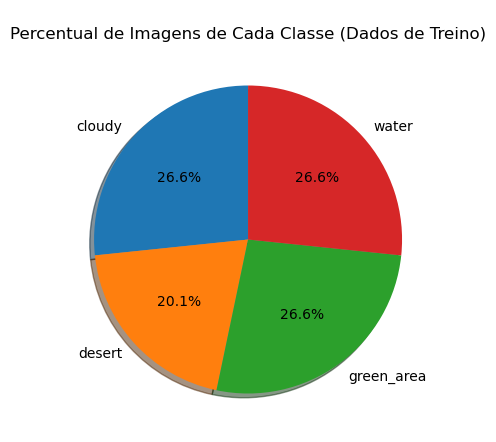

{'cloudy': 1049, 'desert': 790, 'green_area': 1049, 'water': 1049}


In [ ]:
# Plot
fig1, ax1 = plt.subplots(figsize = (5, 5), subplot_kw = dict(aspect = "equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow = True,
        textprops = dict(color = "black"),
        autopct = '%1.1f%%',
        startangle = 90)

# Define título do gráfico
plt.title("\nPercentual de Imagens de Cada Classe (Dados de Treino)", color = 'black')

# Visualiza o gráfico
plt.show()
print(image_count)

## 4. Modelo Preditivo - Torchvision

In [ ]:
# Download do modelo pré-treinado de arquitetura DesenNet, incluindo os pesos
modelo = models.densenet121(weights = 'DEFAULT')

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\morai/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
# Carga dos parâmetros do modelo
modelo.parameters()

<generator object Module.parameters at 0x000002CA61678660>

In [ ]:
# Congela os parâmetros do modelo
for param in modelo.parameters():
    param.require_grad = False

### 4.1 Função de Ativação LeakyReLU

In [ ]:
# Arquitetura do modelo
#clf = nn.Sequential(nn.Linear(1024, 460),
                    #nn.LeakyReLu(0.1),
                    #nn.Dropout(0.4),
                    #nn.Linear(460, 5))

### 4.2 Função de Ativação ELU (Exponential Linear)

In [ ]:
# Arquitetura do modelo
#clf = nn.Sequential(nn.Linear(1024, 460),
                    #nn.ELU(),
                    #nn.Dropout(0.4),
                    #nn.Linear(460, 5))

### 4.3 Função de Ativação ReLU

In [ ]:
# Arquitetura do modelo
# Sequência de camadas
clf = nn.Sequential(nn.Linear(1024, 460), # Camada Linear
                    nn.ReLU(), # Camada da Função de Ativação
                    nn.Dropout(0.4), #Camada Drop Out
                    nn.Linear(460, 5)) # Camada Linear

### 4.4 Treino do modelo

In [ ]:
# Adiciona uma camada de classificação do modelo pré-treinado
modelo.classifier = clf

In [ ]:
# Fórmula para visualizar se está usando GPU ou CPU
"""Se disponível usamos GPU. Caso contrário usamos CPU."""
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
# Visualiza o tipo de processamento
device = get_default_device()
print(device)

cpu


In [ ]:
# Envia o modelo para a memória do device
modelo.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# Função de perda
criterion = nn.CrossEntropyLoss()

In [ ]:
# Otimizador
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [ ]:
%%time

# Vamos medir o tempo de execução
total_step = len(dataloader_treino)
print_every = len(dataloader_treino) - 1
loss_values = []
total_step = len(dataloader_treino)
epoch_times = []

# Loop de treinamento pelo número de épocas
for epoch in range(num_epochs):
    
    # Loop por cada batch de imagem/label
    for i, (images, labels) in enumerate(dataloader_treino): 
        
        # Zera o contador de erro
        running_loss = 0.0
        
        # Carrega imagens do batch
        images = images.to(device)
        
        # Carrega labels do batch
        labels = labels.to(device)
        
        # Faz a previsão com o modelo
        outputs = modelo(images)
        
        # Calcula o erro do modelo
        loss = criterion(outputs, labels)
        
        # Zera os gradientes que serão aprendidos
        optimizer.zero_grad()
        
        # Aplica o backpropagation
        loss.backward()
        
        # Aplica a otimização dos gradientes (aqui ocorre o aprendizado)
        optimizer.step()
        
        # Registra o erro do modelo
        running_loss += loss.item() 
        
        # Imprime em intervalos regulares
        if (i+1) % print_every == 0:
            
            loss_values.append(running_loss / print_every)
            
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
            
            running_loss = 0

Epoch [1/5], Step [123/124], Loss: 0.0265: Batch Loss : 0.00021569415684637985
Epoch [2/5], Step [123/124], Loss: 0.2254: Batch Loss : 0.0018325425018139972
Epoch [3/5], Step [123/124], Loss: 0.0005: Batch Loss : 3.7506300335129103e-06
Epoch [4/5], Step [123/124], Loss: 0.0090: Batch Loss : 7.348170700838895e-05
Epoch [5/5], Step [123/124], Loss: 0.0454: Batch Loss : 0.000369091132065145
Wall time: 21min 37s


## 5. Previsões do modelo

In [ ]:
# Cria os arrays que vão receber as previsões
arr_pred = np.empty((0, len(dataset_teste)), int)
arr_label = np.empty((0, len(dataset_teste)), int)

In [ ]:
# Loop das previsões
with torch.no_grad():
    
    # Contadores
    correct = 0
    total = 0
    
    # Loop pelos dados de teste
    for images, labels in dataloader_teste:
        
        # Extrai imagens e labels do batch de teste
        images = images.to(device)
        labels = labels.to(device)
        
        # Previsão com o modelo
        outputs = modelo(images)
        
        # Extrai o maior valor de probabilidade (classe prevista)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = predicted.cpu().numpy()
        lb = labels.cpu().numpy()
        arr_pred = np.append(arr_pred, pred)
        arr_label = np.append(arr_label, lb)
    
    print('Acurácia do modelo em ' + str(len(dataset_teste)) + 'imagens de teste {} %'.format(100 * correct/total))

Acurácia do modelo em 845imagens de teste 36.21301775147929 %


## 6. Avaliação do modelo

In [ ]:
# Função para o plot da matriz de confusão
def plot_confusion_matrix(cm,
                          target_names,
                          title = 'Matriz de Confusão',
                          cmap = None,
                          normalize = True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize = (10, 8))
    plt.imshow(cm, interpolation = 'nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
        
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Label Real')
    plt.xlabel('Label Previsto\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
# Visualiza as métricas
print(metrics.classification_report(arr_label, arr_pred))

              precision    recall  f1-score   support

           0       0.35      0.41      0.38       225
           1       0.25      0.13      0.17       170
           2       0.38      0.33      0.35       225
           3       0.40      0.52      0.45       225

    accuracy                           0.36       845
   macro avg       0.34      0.35      0.34       845
weighted avg       0.35      0.36      0.35       845



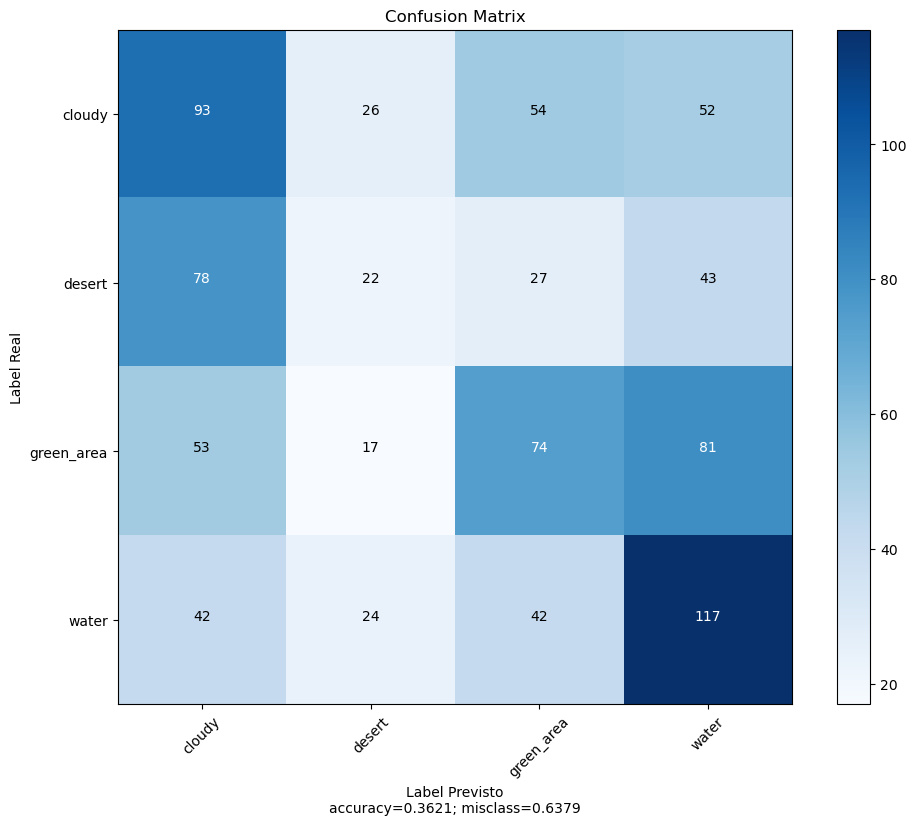

In [ ]:
# Confusion Matrix
cm = metrics.confusion_matrix(arr_label, arr_pred)
plot_confusion_matrix(cm, target_names = nomes_classes, title = 'Confusion Matrix' , normalize = False)